<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/banner.png" alt="Deparatemento de Ingeniería de Sistemas y Computación, Universidad de los Andes">

#  Aplicación de algoritmos para  el análisis de coberturas

**Introducción**

La teledetección es el proceso de **detectar** y **monitorear** las características físicas, químicas y biológicas de la cobertura terrestre. Estas caracteristicas pueden ser estudiadas mediante el análisis de la radiación reflejada y emitida a distancia por los diferentes tipos de coberturas que reposan sobre la superficie terrestre. En el presente notebook se muestran algúnos algoritmos (índices de vegetación) empleados de forma recurrente en la literatura para el estudio de cultivos. Así mismo se muestran algoritmos que permiten mitigar el efecto de las nuebes que producen valores inválidos para el análisis de un cultivo. Luego de realizar un análisis de las covertura terrestre con estos índices, se exportan los resultados de los análisis en formatos conocidos para su exploración en herramientas GIS como ArcGIS.

**Objetivo**

Familiarizarse con el proceso de análisis de imágenes satelitales usando el cubo de datos.

**Contenido**

1. Importar librerías
2. Consulta del área de estudio
3. Cálculo de índices de vegetación
4. Guardar resultados de análisis en fortamto netcdf
5. Guardar resultados de análisis en formato geotiff

## 1. Importar librerías

___

En esta sección se importan las librerías cuya funicionalidades particulares son requeridas.

In [1]:
# las funcionalidades del open data cube son accedidas 
# por medio de la librería datacube
import datacube

# Manipulación de datasets
import xarray as xr

# Manipulación de datos raster
import rasterio

# Librería usada para la carga de polígonos
import geopandas as gpd

# Librería usada para visualización de datos
import matplotlib as mpl
import matplotlib.pyplot as plt

# Desactiva los warnings en el notebook
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Configuración de Drivers para leer polígonos en formato KMLs
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

## 2. Consulta del área de estudio
___

(Opción 1) Consultar un área a partir de un polígono

    latitude=(5.482742764560578, 5.599560141454585),
    longitude=(-72.98455102539063, -72.86891119384765),


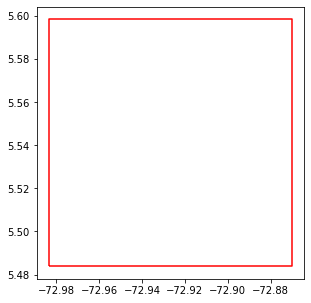

In [2]:
# Carga del archivo .kml
df_polygon = gpd.read_file("polygon/tota_lake.kml",driver='KML')
df_polygon = df_polygon.to_crs('EPSG:4326')

# Pintar el polígono seleccionado
fig, ax = plt.subplots(figsize=(5,5))
df_polygon.boundary.plot(ax=ax,color='red')

# Obtención de la geometría del polígono del GeoDataFrame
geometry_predio = df_polygon['geometry'][0]

# Obtención de los límites del cuadrado que enmarca el polígono
minx, miny, maxx, maxy = geometry_predio.bounds

# Aumento del aŕea del cuadrado para "EPSG:32719"
buffer = 0.001

minx = minx - buffer
miny = miny - buffer
maxx = maxx + buffer
maxy = maxy + buffer

# Parámetros de área a ser consultada
set_study_area_lat = (miny,maxy)
set_study_area_lon = (minx,maxx)

print(f'    latitude={set_study_area_lat},')
print(f'    longitude={set_study_area_lon},')

(Opción 2) Consultar un área a partir de un punto

Los coordenadas del punto a seleccionar pueden ser obtenidas a travez de herramientas GIS como google maps. Este punto debe estar comprendido en el área que desea estudiar. El punto definido será empleado para la generación de un cuadrado que finálmente será usado para consultar el área de estudio. La variable `buffer` permite ampliar o disminuir las dimensiones del cuadrado. Lo anterior es equivalente a disminuir o ampliar el área de estudio a consultar en el open data cube.

<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/latlong_buffer.png" alt="Definición área de estudio" width="20%">

In [3]:
# Definición de las coordenadas del punto
central_lat = 5.547964746532565
central_lon =  -72.9284962779124

# Aumento del aŕea del cuadrado para "EPSG:4326"
# 11.1 kilómetros
buffer = 0.1

# Calculo del cuadro delimitador (bounding box) para el área de estudio
set_study_area_lat = (central_lat - buffer, central_lat + buffer)
set_study_area_lon = (central_lon - buffer, central_lon + buffer)

print(f'    latitude={set_study_area_lat},')
print(f'    longitude={set_study_area_lon},')

    latitude=(5.447964746532565, 5.647964746532565),
    longitude=(-73.0284962779124, -72.82849627791241),


Consulta de información sobre el área de interes por medio del open data cube

In [4]:
dc = datacube.Datacube(app="MOOC GEO")

dataset = dc.load(
    product="s2_sen2cor_ard_granule_EO3",
    latitude=(5.447964746532565, 5.647964746532565),
    longitude=(-73.0284962779124, -72.82849627791241),
    time=('2021-01-01', '2021-02-01'),
    measurements=["red","blue","green","nir","swir1","swir2","scl"],
    crs="EPSG:4326",
    output_crs="EPSG:4326",
    resolution=(-0.00008983111,0.00008971023)
)

dataset

<xarray.Dataset>
Dimensions:      (latitude: 2228, longitude: 2230, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-30T17:40:15
  * latitude     (latitude) float64 5.648 5.648 5.648 ... 5.448 5.448 5.448
  * longitude    (longitude) float64 -73.03 -73.03 -73.03 ... -72.83 -72.83
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) uint16 297 123 156 ... 284 266 216
    blue         (time, latitude, longitude) uint16 111 42 98 123 ... 96 105 97
    green        (time, latitude, longitude) uint16 244 106 152 ... 364 340 289
    nir          (time, latitude, longitude) uint16 938 395 544 ... 2018 1888
    swir1        (time, latitude, longitude) uint16 855 855 428 ... 1455 1584
    swir2        (time, latitude, longitude) uint16 568 568 282 ... 718 718 820
    scl          (time, latitude, longitude) uint8 7 7 2 2 2 2 4 ... 4 4 4 4 4 4
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

En caso de que la consulta arroje como resultado varios periodos de tiempo, el código que se muestra a continuación permite visualizar la imágen en RGB de todos estos periodos.

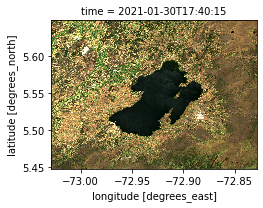

In [5]:
rgb = dataset[["red","green","blue"]].to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(col='time',col_wrap=4,add_colorbar=False,vmin=0,vmax=1500)

Si desea visualizar un periodo de tiempo en particular puede modificar el valor de la variable  `time_index` entre `0` el `número de periodos de tiempo - 1` que haya retornado como resultado la consulta. Observe que en el código que se muestra a continuación es posible ampliar el tamaño de la figura mostrada usando el parámetro `figsize` que se encuentra en la última linea de la celda `img = rgb.plot.imshow(add_colorbar=False,vmin=0,vmax=1500,figsize=(5,5))`. **NOTA:** entre más grande es la imágen, más tiempo, de procesamiento, se requiere para ser visualizada.

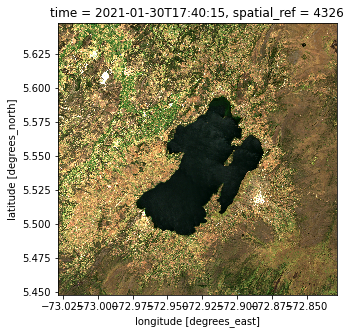

In [6]:
time_index = 0

rgb = dataset[["red","green","blue"]].isel(time=time_index).to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(add_colorbar=False,vmin=0,vmax=1500,figsize=(5,5))

## 3. Cálculo de índices de vegetación
___
Los índices de  vegetación son  el  resultado de  operar  aritméticamente  los  componentes espectrales (bandas) de una imagen satelital. El valor de estos índices, en la mayoría de los  casos, realza  las  propiedades  fenológicas  de  los  cultivos. Ejemplos  de  índices  de vegetación empleados empleados de forma recurrente en la literatura para el análisis de cultivos son: **Normalized Difference Vegetation Index (NDVI)**, y **Enhanced Vegetation Index (EVI)**. Otros índices de vegetación encontrados en la literatura son **Ratio Vegetation Index (RVI)** y **Soil Adjusted Vegetation Index (SAVI)**. Puede encontrar más información sobre índices [aquí](https://www.opendatacube.org/dcal-spectral-products).

### Normalized Vegetation Index (NDVI)

El  NDVI  es  empleado  para calificar  el  verdor  de  la vegetación  y  es  útil para  evaluar su densidad y salud; para este índice los valores cercanos a `1` corresponden a una vegetación densa, como la  encontrada  en  bosques o  cultivos  en  su  etapa  de  crecimiento  máximo, mientras que  los valores  cercanos  a  `0` representan  zonas  cuya  vegetación  es  escasa. Finalmente, valores negativos cercanos a `-1` representan indicios de agua.

La ecuaciónque permite el cálculo deesteíndice se muestra a continuación:

`NDVI = (NIR - RED) / (NIR + RED)`

**Cálculo del NDVI**

El open data cube permite operar la información espectral de una imágen de forma sencilla. De esta forma el cálculo del ndvi se reduce a replicar la formula mostrada anteriormente. Observe que una vez calculado el ndvi, este es agregado al dataset resultado como una variable de datos nueva. 

In [7]:
dataset['ndvi'] = (dataset.nir - dataset.red) / (dataset.nir + dataset.red)
dataset

<xarray.Dataset>
Dimensions:      (latitude: 2228, longitude: 2230, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-30T17:40:15
  * latitude     (latitude) float64 5.648 5.648 5.648 ... 5.448 5.448 5.448
  * longitude    (longitude) float64 -73.03 -73.03 -73.03 ... -72.83 -72.83
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) uint16 297 123 156 ... 284 266 216
    blue         (time, latitude, longitude) uint16 111 42 98 123 ... 96 105 97
    green        (time, latitude, longitude) uint16 244 106 152 ... 364 340 289
    nir          (time, latitude, longitude) uint16 938 395 544 ... 2018 1888
    swir1        (time, latitude, longitude) uint16 855 855 428 ... 1455 1584
    swir2        (time, latitude, longitude) uint16 568 568 282 ... 718 718 820
    scl          (time, latitude, longitude) uint8 7 7 2 2 2 2 4 ... 4 4 4 4 4 4
    ndvi         (time, latitude, longitude) float64 0.519 0.5251 ... 0.7947
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

Imágen del NDVI calculado empleando la función `plot` simple.

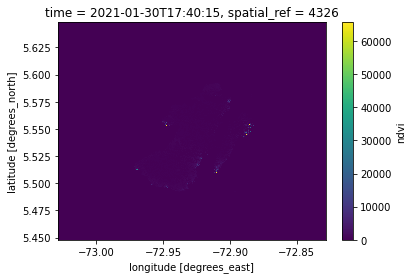

In [8]:
#dataset.ndvi.plot(col='time',col_wrap=4)
#dataset['ndvi'].plot(col='time',col_wrap=4)
dataset.ndvi.plot()

**NOTA:** La imágen anterior parece no reflejar los resultados del ndvi que esperamos. En primera instancia, la barra de colores muestra que el ndvi calculado varia entre `0` y `600`. Pero según la literatura, el cálculo del ndvi entrega valores que varían entre `-1.0` y `1.0`. Por otro lado, la imágen se torna de un único color.

Cuando se trata con imágenes satelitales es común encontrar valores de píxeles inválidos, esto es, 1) pixeles con valores que están por fuera del rango válido de valores de las bandas, (2) píxeles que no tienen información, (3) píxeles que presentan nubes poco densas que no son visibles a simple vista o por el nivel de detalle de la imágen se hace imperceptible, entre otros casos. Dado lo anterior, es prudente remover estos píxeles del análisis original para evitar la propagración de uso de valores de píxel invalidos.

**Enmascaramiento de píxeles inválidos**

El enmascarado es el proceso de eliminar o remover información de píxeles no validos de la imágen para evitar propagar el error al hacer cálculos con estos valores. Una forma de enmascarar la imágen es usando los rangos de valores conocidos del ndvi como criterio de aceptación o eliminación de píxeles.

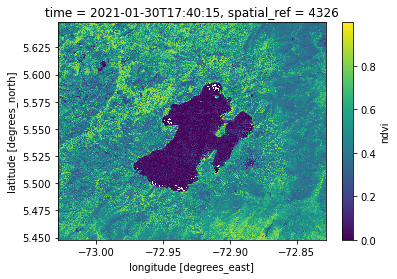

In [9]:
# Generación de máscara que establece que deseamos dejar aquellos píxeles que presentan un ndvi mayor que -1.0
mask_lower = dataset.ndvi >= -1.0

# Generación de máscara que establece que deseamos dejar aquellos píxeles que son menores que 1.0
mask_higher = dataset.ndvi <= 1.0

# Aplicamos ambas máscaras sobre todo el dataset
masked_dataset = dataset.where(mask_lower & mask_higher)

# Imágen del ndvi después de haber removido los valores inválidos para el índice
#masked_dataset.ndvi.plot(col='time',col_wrap=4)
masked_dataset.ndvi.plot()

**Definir diferentes colores para rangos establecidos de valores**

En algúnos casos se requiere establecer colores específicos para ciertos rangos de valores que permitan distinguir aspectos puntuales de la cobertura estudiada. El código que se muestra a continuación establece colores especificos para rangos definidos de valores del ndvi.

Referencia: los colores empleados en al barra de colores fueron tomados de *[A repository of custom scripts that can be used with Sentinel-Hub services](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/)*

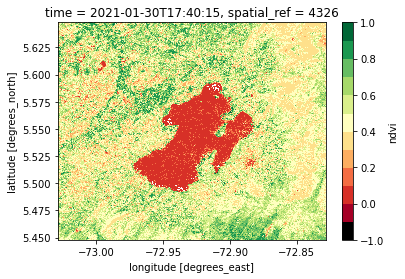

In [10]:
# Definición de colores para cada rango establecido en 'bounds'
cmap = mpl.colors.ListedColormap(
    [
        '#000000', 
        '#a50026',
        '#d73027',
        '#f46d43',
        '#fdae61',
        '#fee08b',
        '#ffffbf',
        '#d9ef8b',
        '#a6d96a',
        '#66bd63',
        '#1a9850',
        '#006837'
    ]
)

# Rangos de valores establecidos
bounds = [-1.0, -0.2, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Genera una capa de normalización de los datos basada en los intérvalos establecidos en 'bounds'
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Mostrar imágen de la variable de datos ndvi.
#masked_dataset.ndvi.plot(col='time',col_wrap=4,cmap=cmap,norm=norm)
masked_dataset.ndvi.plot(cmap=cmap,norm=norm)

### Enhanced Vegetation Index (EVI)

El índice EVI es similar al NDVI; sin embargo, corrige algunas condiciones atmosféricas y es más sensible en áreas con alta densidad de vegetación. La ecuación que describe el cálculo de este índice se muestra a continuación:

`2 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 10000))`

> **TODO:**  Realice el mismo proceso de análisis del NDVI, pero en este caso para el cálculo del EVI.

## 4. Guardar resultados de análisis en formato netcdf
___

In [11]:
# Selecciono el periodo de tiempo que deseo guardar
time_index = 0
dataset_to_save = masked_dataset.isel(time=time_index)

# Selecciono la banda que deseo guardar
ndvi = dataset_to_save.ndvi

# Elimino la coordenada 'time' del dataset 
ndvi = ndvi.drop('time')
ndvi

<xarray.DataArray 'ndvi' (latitude: 2228, longitude: 2230)>
array([[0.51902834, 0.52509653, 0.55428571, ..., 0.46055804, 0.4202698 ,
        0.41476693],
       [0.49652592, 0.57192982, 0.57166124, ..., 0.45315221, 0.43508772,
        0.41000695],
       [0.5255814 , 0.55284553, 0.50023618, ..., 0.4508519 , 0.44531516,
        0.4290552 ],
       ...,
       [0.57589803, 0.55522719, 0.53300213, ..., 0.74198783, 0.77086035,
        0.76380952],
       [0.56263899, 0.50811574, 0.4980722 , ..., 0.75857687, 0.75723014,
        0.76660342],
       [0.52207428, 0.5182781 , 0.50845628, ..., 0.77069035, 0.76707531,
        0.79467681]])
Coordinates:
  * latitude     (latitude) float64 5.648 5.648 5.648 ... 5.448 5.448 5.448
  * longitude    (longitude) float64 -73.03 -73.03 -73.03 ... -72.83 -72.83
    spatial_ref  int32 4326

Guardar resultados de análisis en un archivo .nc

In [12]:
ndvi.to_netcdf('Salidas/ndvi.nc')

## 5. Guardar resultados de análisis en formato geotiff
___

Funciones requeridas para guardar información en geotiff

In [13]:
"""
Las funciones mostradas a continuación fueron tomadas de 
https://github.com/ceos-seo/data_cube_notebooks
"""

def _get_transform_from_xr(data, x_coord='longitude', y_coord='latitude'):
    """Create a geotransform from an xarray.Dataset or xarray.DataArray.
    """

    from rasterio.transform import from_bounds
    geotransform = from_bounds(data[x_coord][0], data[y_coord][-1],
                               data[x_coord][-1], data[y_coord][0],
                               len(data[x_coord]), len(data[y_coord]))
    return geotransform

def write_geotiff_from_xr(tif_path, data, bands=None, no_data=-9999, crs="EPSG:4326",
                          x_coord='longitude', y_coord='latitude'):
    """
    NOTE: Instead of this function, please use `import_export.export_xarray_to_geotiff()`.
    Export a GeoTIFF from an `xarray.Dataset`.
    Parameters
    ----------
    tif_path: string
        The path to write the GeoTIFF file to. You should include the file extension.
    data: xarray.Dataset or xarray.DataArray
    bands: list of string
        The bands to write - in the order they should be written.
        Ignored if `data` is an `xarray.DataArray`.
    no_data: int
        The nodata value.
    crs: string
        The CRS of the output.
    x_coord, y_coord: string
        The string names of the x and y dimensions.
    """
    if isinstance(data, xr.DataArray):
        height, width = data.sizes[y_coord], data.sizes[x_coord]
        count, dtype = 1, data.dtype
    else:
        if bands is None:
            bands = list(data.data_vars.keys())
        else:
            assrt_msg_begin = "The `data` parameter is an `xarray.Dataset`. "
            assert isinstance(bands, list), assrt_msg_begin + "Bands must be a list of strings."
            assert len(bands) > 0 and isinstance(bands[0], str), assrt_msg_begin + "You must supply at least one band."
        height, width = data.dims[y_coord], data.dims[x_coord]
        count, dtype = len(bands), data[bands[0]].dtype
    with rasterio.open(
            tif_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=count,
            dtype=dtype,
            crs=crs,
            transform=_get_transform_from_xr(data, x_coord=x_coord, y_coord=y_coord),
            nodata=no_data) as dst:
        if isinstance(data, xr.DataArray):
            dst.write(data.values, 1)
        else:
            for index, band in enumerate(bands):
                dst.write(data[band].values, index + 1)
    dst.close()

Guardar resultados de análisis en un archivo .tif

In [15]:
write_geotiff_from_xr(
    tif_path='Salidas/ndvi.tif', 
    data=ndvi, 
    bands=['ndvi'], 
    no_data=-9999, 
    crs="EPSG:4326",
    x_coord='longitude',
    y_coord='latitude'
)